## Prediksi Saham PT Astra Internasional Tbk dengan model Multilayer Perceptron

### Tugas 1  

Benediktus Sashenka   
10117080

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt

In [2]:
# Definisikan kelas sehingga lebih mudah diakses
        
class data():
    
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

class train_parameters():
    
    def __init__(self, hlayers_neuron, num_iterations, learning_rate):
        self.layers = len(hlayers_neuron) + 2
        
        self.neurons = np.append(np.append([1], hlayers_neuron),[1])
        
        self.iter = num_iterations
        self.alp  = learning_rate

In [4]:
# Fungsi konversi data menjadi pada selang (0,1)

norm = lambda X: (X - min(X))/(max(X) - min(X))

# Fungsi aktivasi sigmoid dan turunannya

sg  = lambda Z: 1/(1 + np.exp(-Z))
dsg = lambda A: A*(1 - A)

# Fungsi prediksi plot

def prediction_plot(Y, Y_predict):
    plt.plot(Y, label = 'actual series')
    plt.plot(Y_predict, label = 'predicted series')
    plt.legend()
    plt.show()

In [7]:
# Data saham PT Astra Internasional Tbk sejak 19 Februari 2016 
# Ekstrak data 'Adj Close' dan ambil 1000 observasi terakhir, 800 data training dan 200 data testing
# Dalam model prediksi menggunakan 1 data sebelumnya, sehingga indeks X = Y-1

dataset_raw = pd.read_csv('ASII_10117080.csv')
dataset_raw['Adj Close'].fillna(dataset_raw['Adj Close'].mean(), inplace=True)
dataset = norm(np.array(dataset_raw['Adj Close']))

n_train = 800
n_test  = 200

X_train    = dataset[-(n_train+n_test+1):-(n_test+1)].reshape(n_train, 1)
Y_train    = dataset[-(n_train+n_test):-n_test].reshape(n_train, 1)
train_data = data(X_train, Y_train)

X_test    = dataset[-(n_test+1):-1].reshape(n_test, 1)
Y_test    = dataset[-n_test:].reshape(n_test, 1)
test_data = data(X_test, Y_test)

In [5]:
# Fungsi forward propagation

def forward(W, b, X, Y, lay):
    
    A, Z = [X], [[]]  
    for i in range(1, lay):
        Zi = A[i-1]@W[i-1] + b[i-1]
        Ai = sg(Zi)
        Z.append(Zi)  
        A.append(Ai)
    
    Yp   = A[-1]
    e    = Y - Yp
    cost = sum(e.T@e / len(X))
    
    return A, e, cost[0]

# Fungsi backward propagation

def backward(A, e, W, X, lay):
    
    N    = len(X)
    iota = np.ones(N)
    dA   = [-2*e / N]
    dZ   = [dA * dsg(A[-1])]
    dW   = []
    db   = []
    for i in range(lay-2, -1, -1):
        dAi = dZ[-1] @ W[i].T
        dZi = dAi * dsg(A[i])
        dWi = A[i].T @ dZ[-1]
        dbi = iota   @ dZ[-1]
        dA.append(dAi)
        dZ.append(dZi)
        dW.append(dWi)
        db.append(dbi)
    
    dW.reverse()
    db.reverse()
    
    return dW, db

# Fungsi untuk training model

def training(W, b, X_train, Y_train, train_param):
    
    N = len(X_train)
    k = train_param.layers
    
    # Forward and backward propagation
    
    A, e, cost = forward(W, b, X_train, Y_train, train_param.layers)
    dW, db     = backward(A, e, W, X_train, train_param.layers)
    
    # Updating parameter
    
    for i in range(0, k-1):
        W[i] -= train_param.alp * dW[i][0]
        b[i] -= train_param.alp * db[i][0]
        
    return W, b, A[-1], cost

In [6]:
class MLP():
    
    def __init__(self, train_data, test_data, train_param): 
        
        self.train  = train_data
        self.test   = test_data
        self.tp     = train_param
        
        # Inisiasi parameter w dan b
    
        np.random.seed(20210219)
        W, b = [], []
        for i in range(self.tp.layers - 1):
            W.append(np.random.randn(self.tp.neurons[i], self.tp.neurons[i+1]))
            b.append(np.random.randn(self.tp.neurons[i+1]))
        
        # Dimulai iterasi training
        
        tic = dt.datetime.now()
        
        print('--- Training dimulai ---')
        for i in range(train_param.iter):
            W, b, Yp, cost = training(W, b, self.train.X, self.train.Y, self.tp)
            if (i+1) % (self.tp.iter//10) == 0:
                print('Cost function iterasi ke', i+1, '=', cost)
            
        print('--- Training selesai ---\n')
        
        toc = dt.datetime.now()
        
        self.Yp   = Yp
        self.MSE0 = cost
        self.time = toc - tic
        
        # Testing
        
        A, e, self.MSE1 = forward(W, b, X_test, Y_test, self.tp.layers)
        self.Ytp  = A[-1]
        
    # Informasi training dan plot prediksi
        
    def info(self):
        print('Hidden layer   :', self.tp.layers-2)
        print('Banyak Neuron  :', self.tp.neurons[1:-1])
        print('Banyak iterasi :', self.tp.iter)
        print('Learning rate  :', self.tp.alp)
        print('Waktu training :', self.time)
        print('MSE training   :', self.MSE0)
        print('MSE testing    :', self.MSE1)
        print()
    
    def plot_training(self):
        prediction_plot(self.train.Y, self.Yp)
        
    def plot_testing(self):
        prediction_plot(self.test.Y, self.Ytp)

In [8]:
# Parameter yang akan digunakan dalam model training

hlayers_neuron = np.array([3, 6])
num_iterations = 10000
learning_rate  = 10
train_param    = train_parameters(hlayers_neuron, num_iterations, learning_rate)

--- Training dimulai ---
Cost function iterasi ke 1000 = 0.0018320629833905708
Cost function iterasi ke 2000 = 0.0010763303516905312
Cost function iterasi ke 3000 = 0.0008065333919226917
Cost function iterasi ke 4000 = 0.0006873947384571232
Cost function iterasi ke 5000 = 0.0006334696506787839
Cost function iterasi ke 6000 = 0.000608019695534772
Cost function iterasi ke 7000 = 0.0005966177361411791
Cost function iterasi ke 8000 = 0.0005923930532918747
Cost function iterasi ke 9000 = 0.0005899564093306654
Cost function iterasi ke 10000 = 0.0005882519563045297
--- Training selesai ---

Hidden layer   : 2
Banyak Neuron  : [3 6]
Banyak iterasi : 10000
Learning rate  : 10
Waktu training : 0:00:02.532430
MSE training   : 0.0005882519563045297
MSE testing    : 0.0008198751710234606



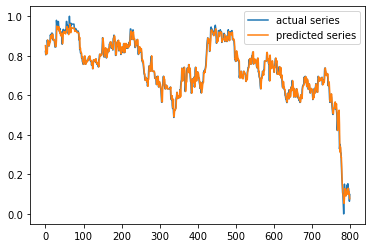

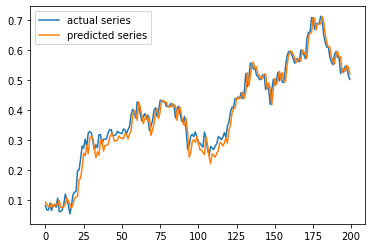

In [9]:
# Eksekusi model

model = MLP(train_data, test_data, train_param)
model.info()
model.plot_training()
model.plot_testing()